In [122]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.model_selection import train_test_split   # for data splitting
from sklearn.metrics import mean_squared_error, r2_score   # for model evaluation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV   # for hyperparameter tuning
from sklearn.preprocessing import StandardScaler, OneHotEncoder   # for data preprocessing
from sklearn.compose import ColumnTransformer   # for applying different preprocessing to different columns
from sklearn.pipeline import Pipeline   # for creating ML pipelines
from sklearn.metrics import r2_score, mean_squared_error # import r2 score and mse

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
# Neural Network library
from tensorflow.keras.models import Sequential      # for building sequential models
from tensorflow.keras.layers import Dense        # for fully connected layers
from tensorflow.keras.optimizers import Adam      # for optimization algorithms
from tensorflow.keras.callbacks import EarlyStopping     # for early stopping to prevent overfitting
from tensorflow.keras.utils import plot_model    # for visualizing model architecture
#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor  # for integrating Keras with scikit-learn

# CNN specific imports
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout  

# Visualization of training process and optimization (console)
from tensorflow.keras.callbacks import History

# library for saving/loading models
import joblib
import os
import json
import pickle
from scipy.stats import wasserstein_distance, entropy # for comparision
from scipy.spatial.distance import jensenshannon # for comparision

In [2]:
# Hyper parameter values
RANDOM_STATE = 42
N_SPLITS = 5
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
target = 'price'
data_path = 'C:/Users/pragy/OneDrive/Desktop/CDC_Submission Project/dataset'    # path to the data folder (Change for you local system)
model_path = 'C:/Users/pragy/OneDrive/Desktop/CDC_Submission Project/saved_models'   # path to save models (Change for your local system)
if not os.path.exists(model_path):
    os.makedirs(model_path)
log_path = 'C:/Users/pragy/OneDrive/Desktop/CDC_Submission Project/logs'   # path to save logs (Change for your local system)
if not os.path.exists(log_path):
    os.makedirs(log_path)
image_path = 'C:/Users/pragy/OneDrive/Desktop/CDC_Submission Project/property_images'   # path to save images (Change for your local system)
image_path_train = image_path + '/train'
image_path_test = image_path + '/test'

In [3]:
def load_image(image_id, base_path):
    image_file = tf.strings.join(
        [base_path, '/', tf.strings.as_string(image_id), '.png']
    )
    img = tf.io.read_file(image_file)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img

def make_dataset(df, X_tab, y, image_base_path, training=True):
    ids = df['id'].values.astype(np.int64)

    if y is not None:
        ds = tf.data.Dataset.from_tensor_slices((ids, X_tab, y.values))
    else:
        ds = tf.data.Dataset.from_tensor_slices((ids, X_tab))

    def _map_train(id_, x_tab, y_):
        img = load_image(id_, image_base_path)
        return {"image": img, "tabular": x_tab}, y_

    def _map_test(id_, x_tab):
        img = load_image(id_, image_base_path)
        return {"image": img, "tabular": x_tab}

    if y is not None:
        ds = ds.map(_map_train, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        ds = ds.map(_map_test, num_parallel_calls=tf.data.AUTOTUNE)

    if training:
        ds = ds.shuffle(2048)

    return ds.batch(32).prefetch(tf.data.AUTOTUNE)

def build_image_encoder():
    base = tf.keras.applications.EfficientNetB3(
        include_top=False,
        weights="imagenet",
        input_shape=(224, 224, 3)
    )

    base.trainable = False  # warm-up phase

    x = base.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.4)(x)

    return models.Model(base.input, x, name="image_encoder")

def build_tabular_encoder(n_features):
    inputs = layers.Input(shape=(n_features,))
    x = layers.Dense(256, activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    return models.Model(inputs, x, name="tabular_encoder")

In [ ]:
df_train = pd.read_csv(data_path + '/encoded_train.csv')
X_train = df_train.drop(columns=[target, 'date', 'id', 'lat', 'long']) 
y_train = df_train[target]
tabular_features = X_train.columns.tolist()
scaler = StandardScaler()
X_tab = scaler.fit_transform(X_train.values.astype(np.float32))

train_ds = make_dataset(
    df_train,
    X_tab,
    y_train,
    image_base_path=image_path_train,
    training=True
)

In [5]:
image_encoder = build_image_encoder()
tabular_encoder = build_tabular_encoder(X_tab.shape[1])

img_input = layers.Input(shape=(224, 224, 3), name="image")
tab_input = layers.Input(shape=(X_tab.shape[1],), name="tabular")

img_feat = image_encoder(img_input)
tab_feat = tabular_encoder(tab_input)

x = layers.Concatenate()([img_feat, tab_feat])

x = layers.Dense(256, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)

x = layers.Dense(128, activation="relu")(x)
output = layers.Dense(1)(x)

model = models.Model(
    inputs={"image": img_input, "tabular": tab_input},
    outputs=output
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[
        tf.keras.metrics.RootMeanSquaredError(),
        tf.keras.metrics.MeanAbsolutePercentageError()
    ]
)

In [6]:
history = model.fit(
    train_ds,
    epochs=15
)
model.save(model_path + '/multimodal_price_predictor.h5')

Epoch 1/15
507/507 [==============================] - 936s 2s/step - loss: 412504915968.0000 - root_mean_squared_error: 642265.4375 - mean_absolute_percentage_error: 98.8310
Epoch 2/15
507/507 [==============================] - 881s 2s/step - loss: 339705200640.0000 - root_mean_squared_error: 582842.3750 - mean_absolute_percentage_error: 83.7055
Epoch 3/15
507/507 [==============================] - 872s 2s/step - loss: 200447950848.0000 - root_mean_squared_error: 447714.1250 - mean_absolute_percentage_error: 51.0040
Epoch 4/15
507/507 [==============================] - 868s 2s/step - loss: 109122510848.0000 - root_mean_squared_error: 330336.9688 - mean_absolute_percentage_error: 35.4644
Epoch 5/15
507/507 [==============================] - 884s 2s/step - loss: 70198370304.0000 - root_mean_squared_error: 264949.7500 - mean_absolute_percentage_error: 30.1183
Epoch 6/15
507/507 [==============================] - 894s 2s/step - loss: 59510956032.0000 - root_mean_squared_error: 243948.6719 

c:\Users\pragy\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [7]:
image_encoder.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="mse"
)

model.fit(train_ds, epochs=10)
model.save(model_path + '/multimodal_price_predictor_tuned.h5')

Epoch 1/10
507/507 [==============================] - 11019s 22s/step - loss: 71911620608.0000
Epoch 2/10
507/507 [==============================] - 4252s 8s/step - loss: 58834661376.0000
Epoch 3/10
507/507 [==============================] - 4473s 9s/step - loss: 55254257664.0000
Epoch 4/10
507/507 [==============================] - 4422s 9s/step - loss: 49239474176.0000
Epoch 5/10
507/507 [==============================] - 4358s 9s/step - loss: 50532646912.0000
Epoch 6/10
507/507 [==============================] - 10660s 21s/step - loss: 50203414528.0000
Epoch 7/10
507/507 [==============================] - 4405s 9s/step - loss: 44623081472.0000
Epoch 8/10


KeyboardInterrupt: 

In [8]:
model.save(model_path + '/multimodal_price_predictor_tuned.h5')

c:\Users\pragy\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
# testing - 
df_test = pd.read_csv(data_path + '/encoded_test.csv')
X_test = df_test.drop(columns=['id', 'date', 'lat', 'long'])
X_test = scaler.transform(X_test.values.astype(np.float32))

test_ds = make_dataset(
    df_test,
    X_test,
    y=None,
    image_base_path=image_path_test,
    training=False
)

price_pred = model.predict(test_ds)
price_pred = price_pred.flatten()

# prediction evaluation and submission file creation
#r2 = r2_score(df_test[target], price_pred)
#rmse = np.sqrt(mean_squared_error(df_test[target], price_pred))

submission = pd.DataFrame({
    'id': df_test['id'],
    'price': price_pred
})

169/169 [==============================] - 294s 2s/step


In [20]:
submission.to_csv(data_path + '/submission_data.csv')
print(submission['price'].mean())

860399.8


c:\Users\pragy\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\pragy\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


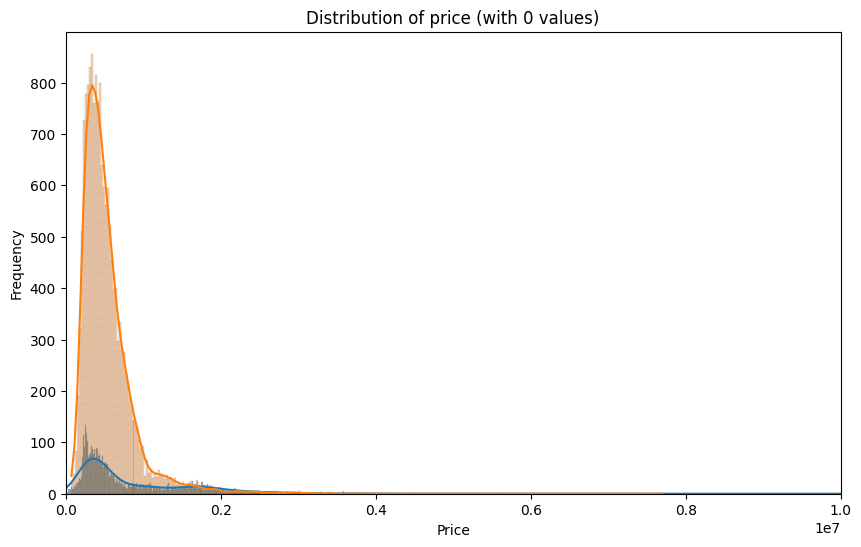

In [113]:
#distribution of values plot of predicted price
plt.figure(figsize = (10,6))
sns.histplot(submission['price'], bins=1000, kde=True)
sns.histplot(df_train['price'], bins = 300, kde = True, linestyle = '--', alpha = 0.3)
plt.title(f'Distribution of price (with 0 values)')
plt.xlim(0,1e7)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

New model with loss function having robustness correction for redundant connections between nets.

In [57]:
class MultimodalDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, image_dir, batch_size=32, img_size=(224, 224), 
                 shuffle=True, tabular_features=tabular_features):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.tabular_features = tabular_features
        self.indexes = np.arange(len(self.df))
        if shuffle:
            np.random.shuffle(self.indexes)
    
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_df = self.df.iloc[batch_indexes]
        
        # Initialize batch arrays
        batch_images = []
        batch_tabular = []
        batch_prices = []
        
        for _, row in batch_df.iterrows():
            # Load image
            img_path = f"{self.image_dir}/{row['id']}.jpg"
            try:
                img = tf.keras.preprocessing.image.load_img(
                    img_path, target_size=self.img_size
                )
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
            except:
                # Create blank image if file not found
                img_array = np.zeros((*self.img_size, 3))
            
            # Get tabular data
            tabular_data = row[self.tabular_features].values.astype('float32')
            
            batch_images.append(img_array)
            batch_tabular.append(tabular_data)
            batch_prices.append(row['price'])
        
        return (
            {
                'image_input': np.array(batch_images),
                'tabular_input': np.array(batch_tabular)
            },
            np.array(batch_prices)
        )
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

class MultimodalTestDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, image_dir, tabular_features,
                 batch_size=32, img_size=(224, 224)):
        
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.tabular_features = tabular_features
        self.indexes = np.arange(len(self.df))

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_df = self.df.iloc[batch_indexes]

        batch_images = []
        batch_tabular = []

        for _, row in batch_df.iterrows():
            # ---- Load image ----
            img_path = f"{self.image_dir}/{row['id']}.jpg"
            try:
                img = tf.keras.preprocessing.image.load_img(
                    img_path, target_size=self.img_size
                )
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
            except:
                img_array = np.zeros((*self.img_size, 3), dtype=np.float32)

            # ---- Tabular data ----
            tabular_data = row[self.tabular_features].values.astype('float32')

            batch_images.append(img_array)
            batch_tabular.append(tabular_data)

        return {
            'image_input': np.array(batch_images),
            'tabular_input': np.array(batch_tabular)
        }
    
class PropertyPricePredictor:
    def __init__(self, model_path, image_dir, batch_size=32):
        self.model = keras.models.load_model(model_path)
        self.image_dir = image_dir
        self.batch_size = batch_size

    def predict(self, test_df, tabular_features):
        test_generator = MultimodalTestDataGenerator(
            df=test_df,
            image_dir=self.image_dir,
            tabular_features=tabular_features,
            batch_size=self.batch_size
        )

        predictions = self.model.predict(
            test_generator,
            verbose=1
        )

        return predictions.flatten()

In [ ]:
def create_multimodal_price_predictor(image_shape=(224, 224, 3), 
                                      num_tabular_features=len(tabular_features)):
    """
    Creates a multimodal CNN + DNN model for price prediction
    """
    
    # ========== 1. IMAGE BRANCH (CNN) ==========
    image_input = keras.Input(shape=image_shape, name='image_input')  # image_path_train + f'/{id}.png'
    
    # CNN Feature Extractor (EfficientNet-based)
    # Base model - using EfficientNetB0 for good performance/speed balance
    base_cnn = keras.applications.EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=image_shape,
        pooling='avg'
    )
    base_cnn.trainable = False  # Freeze base layers initially
    
    # Get CNN features
    cnn_features = base_cnn(image_input)
    
    # Additional CNN layers for domain adaptation
    x = layers.Dense(256, activation='relu')(cnn_features)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    image_output = layers.BatchNormalization()(x)
    
    # ========== 2. TABULAR DATA BRANCH ==========
    tabular_input = keras.Input(shape=(num_tabular_features,), name="tabular_input")
    
    # Normalization layer for tabular data
    normalizer = layers.Normalization()
    
    # Dense layers for tabular data
    y = normalizer(tabular_input)
    y = layers.Dense(512, activation='relu')(y)
    y = layers.BatchNormalization()(y)
    y = layers.Dropout(0.4)(y)
    y = layers.Dense(256, activation='relu')(y)
    y = layers.BatchNormalization()(y)
    y = layers.Dropout(0.3)(y)
    tabular_output = layers.Dense(128, activation='relu')(y)
    
    # ========== 3. FUSION & PREDICTION ==========
    # Concatenate both feature vectors
    combined = layers.concatenate([image_output, tabular_output])
    
    # Joint processing layers
    z = layers.Dense(256, activation='relu')(combined)
    z = layers.BatchNormalization()(z)
    z = layers.Dropout(0.3)(z)
    z = layers.Dense(128, activation='relu')(z)
    z = layers.BatchNormalization()(z)
    z = layers.Dropout(0.2)(z)
    z = layers.Dense(64, activation='relu')(z)
    
    # Output layer (price prediction)
    # Use linear activation for regression
    output = layers.Dense(1, activation='linear', name="price_output")(z)
    
    # Create model
    model = keras.Model(
        inputs=[image_input, tabular_input],
        outputs=output
    )
    
    return model

def create_improved_model(image_shape=(224, 224, 3)):
    """
    Improved version with attention mechanisms
    """
    
    # Image branch with attention
    image_input = keras.Input(shape=image_shape, name="image_input")
    
    base_cnn = keras.applications.EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=image_shape
    )
    base_cnn.trainable = False
    
    # Get feature maps for attention
    cnn_features = base_cnn(image_input)
    
    # Channel attention
    channel_attention = layers.GlobalAveragePooling2D()(cnn_features)
    channel_attention = layers.Dense(cnn_features.shape[-1] // 8, 
                                     activation='relu')(channel_attention)
    channel_attention = layers.Dense(cnn_features.shape[-1], 
                                     activation='sigmoid')(channel_attention)
    channel_attention = layers.Reshape((1, 1, cnn_features.shape[-1]))(channel_attention)
    attended_features = layers.Multiply()([cnn_features, channel_attention])
    
    # Global pooling and processing
    x = layers.GlobalAveragePooling2D()(attended_features)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    image_output = layers.Dropout(0.3)(x)
    
    # Tabular branch with feature grouping
    tabular_input = keras.Input(shape=(len(tabular_features),), name="tabular_input")
    
    # Create multiple sub-networks for different feature types
    # 1. Size features
    size_features = layers.Lambda(lambda x: x[:, 1:6])(tabular_input)  # sqft features
    size_branch = layers.Dense(64, activation='relu')(size_features)
    
    # 2. Categorical encoded features
    cat_features = layers.Lambda(lambda x: x[:, 14:])(tabular_input)  # one-hot encoded
    cat_branch = layers.Dense(128, activation='relu')(cat_features)
    
    # 3. Year features
    year_features = layers.Lambda(lambda x: x[:, 6:8])(tabular_input)
    year_branch = layers.Dense(32, activation='relu')(year_features)
    
    # Merge tabular branches
    merged_tabular = layers.concatenate([size_branch, cat_branch, year_branch])
    merged_tabular = layers.Dense(256, activation='relu')(merged_tabular)
    merged_tabular = layers.BatchNormalization()(merged_tabular)
    tabular_output = layers.Dropout(0.3)(merged_tabular)
    
    # Fusion with cross-attention
    combined = layers.concatenate([image_output, tabular_output])
    
    # Dense prediction layers
    x = layers.Dense(512, activation='relu')(combined)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    # Output
    output = layers.Dense(1, activation='linear', name="price")(x)
    
    return keras.Model(inputs=[image_input, tabular_input], outputs=output)

# Simple one-liner to get predictions
def quick_predict():
    test_df = pd.read_csv(data_path + '/encoded_test.csv')
    X_test_2 = test_df.drop(columns=['date', 'id', 'lat', 'long'])
    
    # Load model and predict
    model = keras.models.load_model('C:/Users/pragy/OneDrive/Desktop/CDC_Submission Project/best_model.h5')
    
    # Prepare test data (assuming you have a test data generator)
    test_generator = MultimodalDataGenerator(
        test_df, 
        image_dir=image_path_test,
        batch_size=32,
        shuffle=False,
        tabular_features = X_test_2.columns.tolist()
    )
    
    # Get predictions
    predictions = model.predict(test_generator)
    
    # Save
    test_df['predicted_price'] = predictions.flatten()
    test_df[['id', 'predicted_price']].to_csv(data_path + '/quick_predictions_newmodel.csv', index=False)
    print("Predictions saved!")

In [27]:
# Create the model
model = create_multimodal_price_predictor(image_shape=(224, 224, 3))
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 tabular_input (InputLayer)  [(None, 64)]                 0         []                            
                                                                                                  
 normalization_4 (Normaliza  (None, 64)                   129       ['tabular_input[0][0]']       
 tion)                                                                                            
                                                                                                  
 image_input (InputLayer)    [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 dense_16 (Dense)            (None, 512)                  33280     ['normalization_4[0][0]'

In [28]:
# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='huber_loss',  # Robust to outliers
    metrics=['mae', 'mse']
)

# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        patience=10,
        restore_best_weights=True,
        monitor='val_loss'
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    ),
    keras.callbacks.ModelCheckpoint(
        'best_model.h5',
        save_best_only=True,
        monitor='val_loss'
    )
]

# Prepare your data
df = df_train
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Create generators
train_gen = MultimodalDataGenerator(train_df, image_dir=image_path_train, batch_size=32)
val_gen = MultimodalDataGenerator(val_df, image_dir=image_path_train, batch_size=32, shuffle=False)

# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
406/406 [==============================] - ETA: 0s - loss: 536313.3125 - mae: 536314.0000 - mse: 415394037760.0000

c:\Users\pragy\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


406/406 [==============================] - 518s 1s/step - loss: 536313.3125 - mae: 536314.0000 - mse: 415394037760.0000 - val_loss: 535903.8750 - val_mae: 535904.4375 - val_mse: 425211985920.0000 - lr: 0.0010
Epoch 2/50
406/406 [==============================] - ETA: 0s - loss: 526685.1875 - mae: 526685.6250 - mse: 405120679936.0000

c:\Users\pragy\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


406/406 [==============================] - 482s 1s/step - loss: 526685.1875 - mae: 526685.6250 - mse: 405120679936.0000 - val_loss: 526881.9375 - val_mae: 526882.5000 - val_mse: 415683477504.0000 - lr: 0.0010
Epoch 3/50
406/406 [==============================] - ETA: 0s - loss: 491544.1250 - mae: 491544.7500 - mse: 369754013696.0000

c:\Users\pragy\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


406/406 [==============================] - 519s 1s/step - loss: 491544.1250 - mae: 491544.7500 - mse: 369754013696.0000 - val_loss: 499182.9062 - val_mae: 499183.2188 - val_mse: 388513628160.0000 - lr: 0.0010
Epoch 4/50
406/406 [==============================] - ETA: 0s - loss: 419199.1875 - mae: 419199.5938 - mse: 304734371840.0000

c:\Users\pragy\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


406/406 [==============================] - 1821s 4s/step - loss: 419199.1875 - mae: 419199.5938 - mse: 304734371840.0000 - val_loss: 422561.7812 - val_mae: 422562.1875 - val_mse: 306200117248.0000 - lr: 0.0010
Epoch 5/50
406/406 [==============================] - ETA: 0s - loss: 316164.0625 - mae: 316164.7812 - mse: 221328277504.0000

c:\Users\pragy\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


406/406 [==============================] - 485s 1s/step - loss: 316164.0625 - mae: 316164.7812 - mse: 221328277504.0000 - val_loss: 228904.4688 - val_mae: 228905.0156 - val_mse: 161042579456.0000 - lr: 0.0010
Epoch 6/50
406/406 [==============================] - ETA: 0s - loss: 233230.3125 - mae: 233230.8281 - mse: 149787000832.0000

c:\Users\pragy\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


406/406 [==============================] - 469s 1s/step - loss: 233230.3125 - mae: 233230.8281 - mse: 149787000832.0000 - val_loss: 191797.7344 - val_mae: 191798.2812 - val_mse: 120032575488.0000 - lr: 0.0010
Epoch 7/50
406/406 [==============================] - 471s 1s/step - loss: 191929.5156 - mae: 191930.0156 - mse: 108808503296.0000 - val_loss: 217261.0469 - val_mae: 217261.4844 - val_mse: 98758950912.0000 - lr: 0.0010
Epoch 8/50
406/406 [==============================] - 465s 1s/step - loss: 175967.8906 - mae: 175968.4688 - mse: 91537604608.0000 - val_loss: 194915.3906 - val_mae: 194915.8750 - val_mse: 80645726208.0000 - lr: 0.0010
Epoch 9/50
406/406 [==============================] - 471s 1s/step - loss: 171935.9375 - mae: 171936.4219 - mse: 82029232128.0000 - val_loss: 376787.5938 - val_mae: 376788.1250 - val_mse: 185186566144.0000 - lr: 0.0010
Epoch 10/50
406/406 [==============================] - ETA: 0s - loss: 167548.7656 - mae: 167549.2812 - mse: 76468453376.0000

c:\Users\pragy\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


406/406 [==============================] - 468s 1s/step - loss: 167548.7656 - mae: 167549.2812 - mse: 76468453376.0000 - val_loss: 173162.3906 - val_mae: 173162.8906 - val_mse: 82268094464.0000 - lr: 0.0010
Epoch 11/50
406/406 [==============================] - ETA: 0s - loss: 166894.8594 - mae: 166895.2812 - mse: 76279062528.0000

c:\Users\pragy\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


406/406 [==============================] - 471s 1s/step - loss: 166894.8594 - mae: 166895.2812 - mse: 76279062528.0000 - val_loss: 167584.2188 - val_mae: 167584.7344 - val_mse: 88783642624.0000 - lr: 0.0010
Epoch 12/50
406/406 [==============================] - 468s 1s/step - loss: 163759.5625 - mae: 163760.0312 - mse: 73990586368.0000 - val_loss: 212603.7344 - val_mae: 212604.2500 - val_mse: 88079990784.0000 - lr: 0.0010
Epoch 13/50
406/406 [==============================] - 467s 1s/step - loss: 159888.7500 - mae: 159889.2500 - mse: 71519264768.0000 - val_loss: 345397.5625 - val_mae: 345398.1250 - val_mse: 161157906432.0000 - lr: 0.0010
Epoch 14/50
406/406 [==============================] - ETA: 0s - loss: 156138.6562 - mae: 156139.1250 - mse: 68827578368.0000

c:\Users\pragy\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


406/406 [==============================] - 469s 1s/step - loss: 156138.6562 - mae: 156139.1250 - mse: 68827578368.0000 - val_loss: 167310.7344 - val_mae: 167311.1875 - val_mse: 73940271104.0000 - lr: 0.0010
Epoch 15/50
406/406 [==============================] - ETA: 0s - loss: 156320.4219 - mae: 156320.9844 - mse: 69374574592.0000

c:\Users\pragy\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


406/406 [==============================] - 469s 1s/step - loss: 156320.4219 - mae: 156320.9844 - mse: 69374574592.0000 - val_loss: 162896.1250 - val_mae: 162896.6406 - val_mse: 83926515712.0000 - lr: 0.0010
Epoch 16/50
406/406 [==============================] - 470s 1s/step - loss: 155674.4531 - mae: 155675.0312 - mse: 69046665216.0000 - val_loss: 221885.5312 - val_mae: 221886.0312 - val_mse: 125434691584.0000 - lr: 0.0010
Epoch 17/50
406/406 [==============================] - ETA: 0s - loss: 156624.2031 - mae: 156624.7031 - mse: 69699895296.0000

c:\Users\pragy\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


406/406 [==============================] - 471s 1s/step - loss: 156624.2031 - mae: 156624.7031 - mse: 69699895296.0000 - val_loss: 162043.4688 - val_mae: 162044.0156 - val_mse: 73783967744.0000 - lr: 0.0010
Epoch 18/50
406/406 [==============================] - 470s 1s/step - loss: 155335.4531 - mae: 155335.9062 - mse: 69298962432.0000 - val_loss: 173050.5938 - val_mae: 173051.0781 - val_mse: 93565632512.0000 - lr: 0.0010
Epoch 19/50
406/406 [==============================] - 472s 1s/step - loss: 156049.7344 - mae: 156050.2656 - mse: 70211026944.0000 - val_loss: 194972.3125 - val_mae: 194972.7969 - val_mse: 108518178816.0000 - lr: 0.0010
Epoch 20/50
406/406 [==============================] - 471s 1s/step - loss: 154600.6094 - mae: 154601.2188 - mse: 69071478784.0000 - val_loss: 192141.7344 - val_mae: 192142.2188 - val_mse: 104139915264.0000 - lr: 0.0010
Epoch 21/50
406/406 [==============================] - 469s 1s/step - loss: 154386.6406 - mae: 154387.1719 - mse: 68470353920.0000 - v

c:\Users\pragy\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


406/406 [==============================] - 461s 1s/step - loss: 155256.0938 - mae: 155256.5000 - mse: 69090459648.0000 - val_loss: 157538.1250 - val_mae: 157538.6875 - val_mse: 76444286976.0000 - lr: 0.0010
Epoch 23/50
406/406 [==============================] - ETA: 0s - loss: 154229.2188 - mae: 154229.7031 - mse: 67346776064.0000

c:\Users\pragy\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


406/406 [==============================] - 473s 1s/step - loss: 154229.2188 - mae: 154229.7031 - mse: 67346776064.0000 - val_loss: 147127.1406 - val_mae: 147127.6250 - val_mse: 66819944448.0000 - lr: 0.0010
Epoch 24/50
406/406 [==============================] - 485s 1s/step - loss: 153343.9375 - mae: 153344.4688 - mse: 67360120832.0000 - val_loss: 154663.5312 - val_mae: 154664.0312 - val_mse: 76117090304.0000 - lr: 0.0010
Epoch 25/50
406/406 [==============================] - 481s 1s/step - loss: 153365.1250 - mae: 153365.6094 - mse: 68176986112.0000 - val_loss: 175895.7344 - val_mae: 175896.2188 - val_mse: 76720816128.0000 - lr: 0.0010
Epoch 26/50
406/406 [==============================] - 468s 1s/step - loss: 153106.8750 - mae: 153107.4531 - mse: 68353314816.0000 - val_loss: 160759.5469 - val_mae: 160760.0312 - val_mse: 79456534528.0000 - lr: 0.0010
Epoch 27/50
406/406 [==============================] - 467s 1s/step - loss: 150798.5938 - mae: 150799.1562 - mse: 66085150720.0000 - val

c:\Users\pragy\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


406/406 [==============================] - 467s 1s/step - loss: 149808.7188 - mae: 149809.2188 - mse: 66204717056.0000 - val_loss: 145131.2656 - val_mae: 145131.7812 - val_mse: 68147167232.0000 - lr: 5.0000e-04
Epoch 30/50
406/406 [==============================] - 471s 1s/step - loss: 149205.6875 - mae: 149206.2031 - mse: 65023954944.0000 - val_loss: 155154.6250 - val_mae: 155155.1094 - val_mse: 73316384768.0000 - lr: 5.0000e-04
Epoch 31/50
406/406 [==============================] - 466s 1s/step - loss: 150162.6875 - mae: 150163.2812 - mse: 65378619392.0000 - val_loss: 181249.6719 - val_mae: 181250.1875 - val_mse: 91940995072.0000 - lr: 5.0000e-04
Epoch 32/50
406/406 [==============================] - 468s 1s/step - loss: 150727.8906 - mae: 150728.4531 - mse: 66694402048.0000 - val_loss: 156083.6875 - val_mae: 156084.2344 - val_mse: 73017311232.0000 - lr: 5.0000e-04
Epoch 33/50
406/406 [==============================] - 472s 1s/step - loss: 149457.9062 - mae: 149458.4375 - mse: 651888

c:\Users\pragy\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


406/406 [==============================] - 468s 1s/step - loss: 148319.3906 - mae: 148319.8750 - mse: 64521015296.0000 - val_loss: 144113.4062 - val_mae: 144113.9219 - val_mse: 64716341248.0000 - lr: 2.5000e-04
Epoch 36/50
406/406 [==============================] - 469s 1s/step - loss: 146249.8906 - mae: 146250.4062 - mse: 62851416064.0000 - val_loss: 157669.1406 - val_mae: 157669.6719 - val_mse: 74651754496.0000 - lr: 2.5000e-04
Epoch 37/50
406/406 [==============================] - 467s 1s/step - loss: 147335.0938 - mae: 147335.5781 - mse: 64283070464.0000 - val_loss: 179779.1250 - val_mae: 179779.6250 - val_mse: 90876887040.0000 - lr: 2.5000e-04
Epoch 38/50
406/406 [==============================] - 466s 1s/step - loss: 147300.6875 - mae: 147301.1875 - mse: 63138332672.0000 - val_loss: 148360.6406 - val_mae: 148361.1562 - val_mse: 68694589440.0000 - lr: 2.5000e-04
Epoch 39/50
406/406 [==============================] - 467s 1s/step - loss: 147347.0156 - mae: 147347.6094 - mse: 641357

c:\Users\pragy\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


406/406 [==============================] - 467s 1s/step - loss: 146217.7812 - mae: 146218.2656 - mse: 62483611648.0000 - val_loss: 143186.5000 - val_mae: 143186.9844 - val_mse: 64231223296.0000 - lr: 2.5000e-04
Epoch 41/50
406/406 [==============================] - 466s 1s/step - loss: 146928.8906 - mae: 146929.4375 - mse: 63758966784.0000 - val_loss: 190813.3906 - val_mae: 190813.8906 - val_mse: 99294371840.0000 - lr: 2.5000e-04
Epoch 42/50
406/406 [==============================] - 494s 1s/step - loss: 146096.2344 - mae: 146096.6719 - mse: 62699212800.0000 - val_loss: 152170.5000 - val_mae: 152170.9844 - val_mse: 71388233728.0000 - lr: 2.5000e-04
Epoch 43/50
406/406 [==============================] - 471s 1s/step - loss: 147004.8438 - mae: 147005.3125 - mse: 63553179648.0000 - val_loss: 144493.8438 - val_mae: 144494.2969 - val_mse: 66520899584.0000 - lr: 2.5000e-04
Epoch 44/50
406/406 [==============================] - 474s 1s/step - loss: 145012.2344 - mae: 145012.7344 - mse: 626870

c:\Users\pragy\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


406/406 [==============================] - 467s 1s/step - loss: 145978.9062 - mae: 145979.3438 - mse: 63384514560.0000 - val_loss: 139381.2656 - val_mae: 139381.7500 - val_mse: 61847281664.0000 - lr: 2.5000e-04
Epoch 46/50
406/406 [==============================] - 471s 1s/step - loss: 145307.1406 - mae: 145307.6719 - mse: 63339900928.0000 - val_loss: 145247.2656 - val_mae: 145247.7656 - val_mse: 67810050048.0000 - lr: 2.5000e-04
Epoch 47/50
406/406 [==============================] - 470s 1s/step - loss: 146821.8281 - mae: 146822.2656 - mse: 63854153728.0000 - val_loss: 174275.6875 - val_mae: 174276.2031 - val_mse: 88301445120.0000 - lr: 2.5000e-04
Epoch 48/50
406/406 [==============================] - 469s 1s/step - loss: 145425.1094 - mae: 145425.5781 - mse: 62487625728.0000 - val_loss: 144058.2969 - val_mae: 144058.7812 - val_mse: 65845346304.0000 - lr: 2.5000e-04
Epoch 49/50
406/406 [==============================] - 473s 1s/step - loss: 147030.5469 - mae: 147031.0000 - mse: 636668

In [58]:

# ---- Load test data ----
test_df = pd.read_csv(data_path + '/encoded_test.csv')

X_test_2 = test_df.drop(columns=['date', 'id', 'lat', 'long'])

# ---- Initialize predictor ----
predictor = PropertyPricePredictor(
    model_path='C:/Users/pragy/OneDrive/Desktop/CDC_Submission Project/best_model.h5',
    image_dir=image_path_test,
    batch_size=32
)

# ---- Generate predictions ----
test_df['predicted_price'] = predictor.predict(
    test_df=test_df,
    tabular_features=X_test_2.columns.tolist()
)

# ---- Save results ----
test_df[['id', 'predicted_price']].to_csv(
    data_path + '/test_predictions.csv',
    index=False
)


169/169 [==============================] - 154s 901ms/step


In [60]:
test_df['predicted_price'].mean()

553997.0

In [67]:
test_df['predicted_price']

0       268122.62500
1       745002.68750
2       638172.81250
3       829121.81250
4       468354.93750
            ...     
5399    629170.68750
5400    412281.53125
5401    379085.71875
5402    547958.50000
5403    973978.43750
Name: predicted_price, Length: 5404, dtype: float32

c:\Users\pragy\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\pragy\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


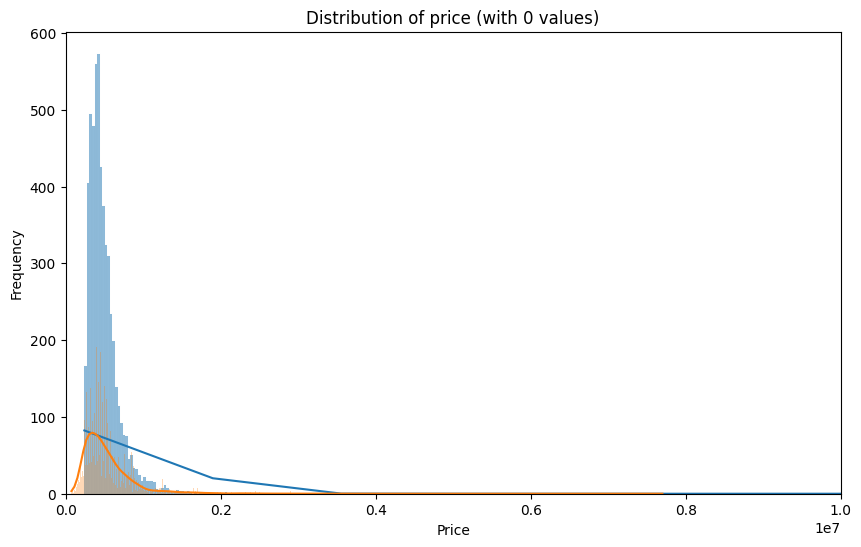

In [112]:
plt.figure(figsize = (10,6))
sns.histplot(test_df['predicted_price'], bins=10000, kde=True)
sns.histplot(df_train['price'], bins = 3000, kde = True, linestyle = '--', alpha = 0.3)
plt.title(f'Distribution of price (with 0 values)')
plt.xlim(0,1e7)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [98]:
# squared error 
sq_err = test_df['predicted_price']*test_df['predicted_price'] - submission['price']*submission['price']
err = test_df['predicted_price'] - submission['price']
print('mean squared error : ', np.sqrt(sq_err.mean()))
print('mean abs error : ', np.abs(err.mean())) 

mean squared error :  4374079.5
mean abs error :  306402.8


c:\Users\pragy\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


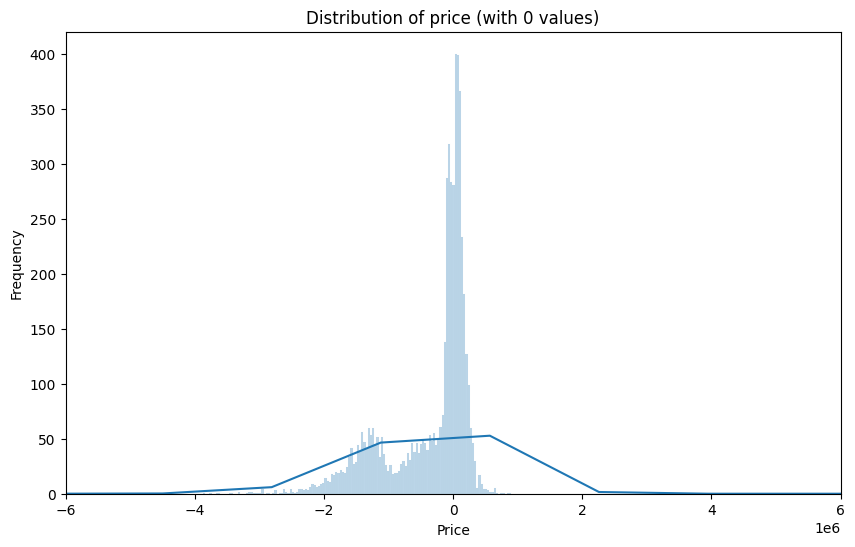

In [108]:
plt.figure(figsize = (10,6))
sns.histplot(test_df['predicted_price'] - submission['price'], bins = 10000, kde = True, linestyle = '--', alpha = 0.3)
plt.title(f'Distribution of price (with 0 values)')
plt.xlim(-6e6,6e6)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [128]:
def optimize_alpha_with_resampling(target, pred1, pred2, trials=500, steps=501):

    n_samples = len(pred1)  # Length to match
    best_alphas = []
    
    alpha_space = np.linspace(0, 1, steps)
    
    for _ in range(trials):
        # 1. Randomly subsample target to match pred1 length
        target_subset = np.random.choice(target, size=n_samples, replace=False)
        
        trial_best_alpha = 0
        min_dist = float('inf')
        
        # 2. Find best alpha for this specific subset
        for alpha in alpha_space:
            combined = alpha * pred1 + (1 - alpha) * pred2
            dist = wasserstein_distance(target_subset, combined)
            
            if dist < min_dist:
                min_dist = dist
                trial_best_alpha = alpha
        
        best_alphas.append(trial_best_alpha)
    
    # The final alpha is the average of optimal alphas across all trials
    final_alpha = np.mean(best_alphas)
    return final_alpha, np.std(best_alphas)

opt_alpha, std_dev = optimize_alpha_with_resampling(df_train['price'], test_df['predicted_price'], submission['price'])

print(f"Optimal Alpha (Mean): {opt_alpha:.4f}")
print(f"Confidence (Std Dev): {std_dev:.4f}")

Optimal Alpha (Mean): 0.8124
Confidence (Std Dev): 0.0089


c:\Users\pragy\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\pragy\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


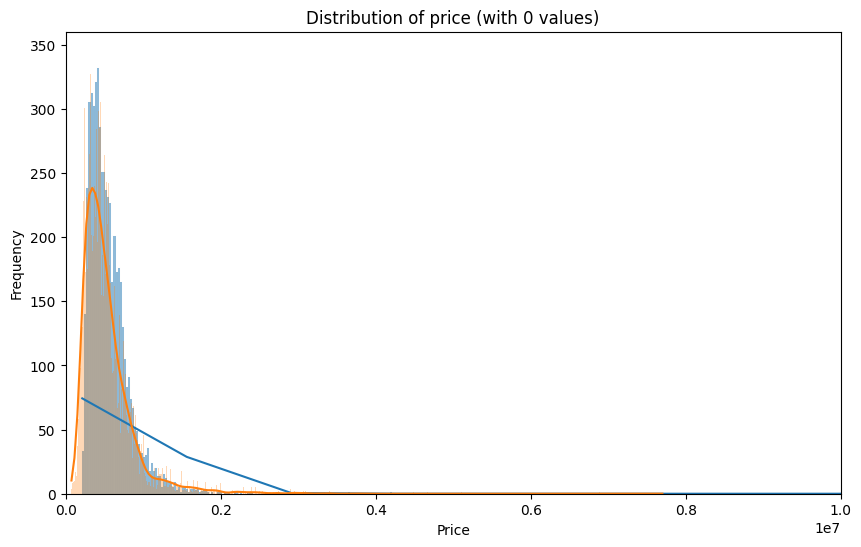

In [130]:
alpha = opt_alpha
better_est = (test_df['predicted_price']*(alpha) + submission['price']*(1-alpha))

plt.figure(figsize = (10,6))
sns.histplot(better_est, bins=10000, kde=True)
sns.histplot(df_train['price'], bins = 1000, kde = True, linestyle = '--', alpha = 0.3)
plt.title(f'Distribution of price (with 0 values)')
plt.xlim(0,1e7)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [131]:
submission['final_price'] = (test_df['predicted_price']*(alpha) + submission['price']*(1-alpha))
submission[['id', 'final_price']].to_csv(data_path + '/subsmission_prices.csv', index = False)